In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re 
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import wordnet
from nltk import pos_tag
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install wordcloud

In [2]:
df = pd.read_csv('rating.csv')
df

,Unnamed: 0,Product_Review,Ratings
0,0,It has great sound quality and bass but after ...,1
1,1,"[BIG UPDATE]IT BROKE ALONG THE RIGHT HINGE, I ...",2
2,2,This is a premium quality product from boAt-Li...,5
3,3,The boAt Rockerz line is boAt's super cheap li...,1
4,4,These are super comfortable and premium lookin...,5
...,...,...,...
49995,49995,Honest rating for this product is 5/5 . Just f...,4
49996,49996,"I have bought 3 of these little guys, for my s...",5
49997,49997,Its a great product. Works really fine. It wil...,4
49998,49998,"Service is very good , I would say to keep up ...",5


In [3]:
df.head()

,Unnamed: 0,Product_Review,Ratings
0,0,It has great sound quality and bass but after ...,1
1,1,"[BIG UPDATE]IT BROKE ALONG THE RIGHT HINGE, I ...",2
2,2,This is a premium quality product from boAt-Li...,5
3,3,The boAt Rockerz line is boAt's super cheap li...,1
4,4,These are super comfortable and premium lookin...,5


In [4]:
df.shape

(50000, 3)

In [5]:
df.columns

Index(['Unnamed: 0', 'Product_Review', 'Ratings'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Product_Review  49920 non-null  object
 1   Ratings         50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [3]:
df.describe()

,Unnamed: 0,Ratings
count,50000.000000,50000.000000
mean,24999.500000,3.655560
std,14433.901067,1.625107
min,0.000000,1.000000
25%,12499.750000,2.000000
50%,24999.500000,4.000000
75%,37499.250000,5.000000
max,49999.000000,5.000000


In [10]:
df['Ratings'].value_counts()

5    24506
1    11232
4     8406
3     3680
2     2176
Name: Ratings, dtype: int64

In [3]:
df.isna().sum()

Unnamed: 0         0
Product_Review    80
Ratings            0
dtype: int64

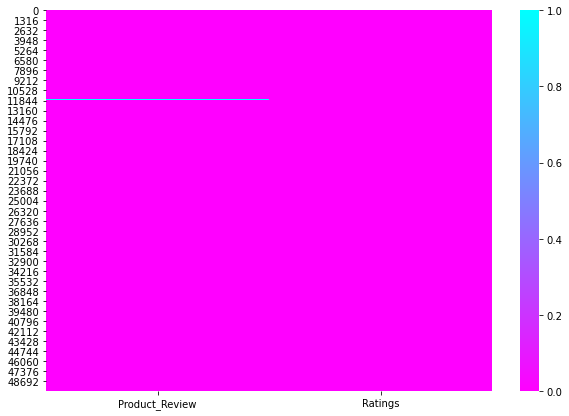

Product_Review    80
Ratings            0
dtype: int64

In [13]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(),cmap="cool_r")
plt.show()
df.isnull().sum()

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [4]:
df.shape

(50000, 2)

In [4]:
# Replacing missing data with 'Review Not Available' using pandas fillna()
df['Product_Review'].fillna('Review Not Available',inplace=True)

In [5]:
df.isnull().sum()

Product_Review    0
Ratings           0
dtype: int64

No missing values are present

# EDA

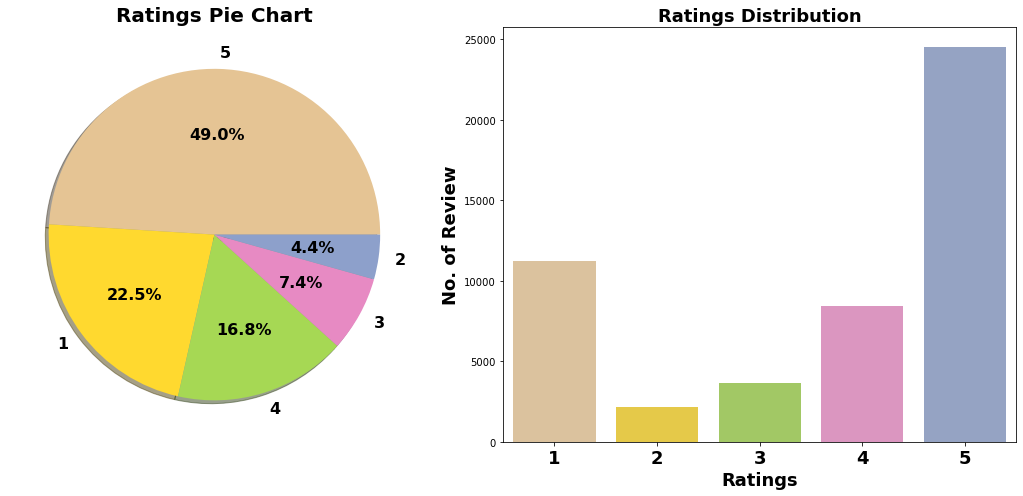

Value Counts of Rating:


5    24506
1    11232
4     8406
3     3680
2     2176
Name: Ratings, dtype: int64

In [8]:
# Pie & Count plot of Ratings
plt.rcParams["figure.autolayout"] = True
sns.set_palette('Set2_r')
f,ax=plt.subplots(1,2,figsize=(15,7))
df['Ratings'].value_counts().plot.pie(autopct='%2.1f%%',
                                textprops ={'fontsize':16 ,'fontweight' :'bold'}, ax=ax[0],shadow=True)
ax[0].set_title('Ratings Pie Chart', fontsize=20,fontweight ='bold')
ax[0].set_ylabel('')
sns.countplot('Ratings',data=df,ax=ax[1])
ax[1].set_title('Ratings Distribution',fontsize=18,fontweight ='bold')
ax[1].set_xlabel("Ratings",fontsize=18,fontweight ='bold')
ax[1].set_ylabel("No. of Review",fontsize=18,fontweight ='bold')
plt.xticks(fontsize=18,fontweight ='bold')
plt.tight_layout()
plt.show()
print('Value Counts of Rating:')
df['Ratings'].value_counts()

In [6]:
print("Average rating given by users is " + str(df['Ratings'].mean()))

Average rating given by users is 3.65556


1. Around 49% customer given 5- star rating followed by 22.5% customer given lowest 1-star rating.

2. Average Rating is 3.65.

# Text Mining

In [7]:
def clean_text(df, df_column_name):
    
    #Converting all messages to lowercase
    df[df_column_name] = df[df_column_name].str.lower()

    #Replace email addresses with 'email'
    df[df_column_name] = df[df_column_name].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

    #Replace URLs with 'webaddress'
    df[df_column_name] = df[df_column_name].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')

    #Replace money symbols with 'dollars' (£ can by typed with ALT key + 156)
    df[df_column_name] = df[df_column_name].str.replace(r'£|\$', 'dollars')
      
    #Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    df[df_column_name] = df[df_column_name].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

    #Replace numbers with 'numbr'
    df[df_column_name] = df[df_column_name].str.replace(r'\d+(\.\d+)?', 'numbr')

    #Remove punctuation
    df[df_column_name] = df[df_column_name].str.replace(r'[^\w\d\s]', ' ')

    #Replace whitespace between terms with a single space
    df[df_column_name] = df[df_column_name].str.replace(r'\s+', ' ')

    #Remove leading and trailing whitespace
    df[df_column_name] = df[df_column_name].str.replace(r'^\s+|\s+?$', '')
    
    #Remove stopwords
    stop_words = set(stopwords.words('english') + ['u', 'ü', 'â', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
    df[df_column_name] = df[df_column_name].apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))

In [8]:
clean_text(df, 'Product_Review')
df['Product_Review'].tail(3)

49997    great product works really fine usually numbr ...
49998    service good would say keep good work goin fli...
49999    buy need bigger coverage buy repeater router c...
Name: Product_Review, dtype: object

In [9]:
#Tokenizing the data using RegexpTokenizer
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')
df['Product_Review'] = df['Product_Review'].apply(lambda x: tokenizer.tokenize(x.lower()))
df.head()

,Product_Review,Ratings
0,"[great, sound, quality, bass, numbr, months, u...",1
1,"[big, update, broke, along, right, hinge, wear...",2
2,"[premium, quality, product, boat, lifestyle, p...",5
3,"[boat, rockerz, line, boat, super, cheap, line...",1
4,"[super, comfortable, premium, looking, headpho...",5


In [10]:
# Lemmatizing and then Stemming with Snowball to get root words and further reducing characters
stemmer = SnowballStemmer("english")
import gensim
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

#Tokenize and Lemmatize
def preprocess(text):
    result=[]
    for token in text:
        if len(token)>=3:
            result.append(lemmatize_stemming(token))
            
    return result

In [14]:
!pip install gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:
      Successfully uninstalled Cython-0.29.23


In [11]:
#Processing review with above Function
processed_review = []

for doc in df.Product_Review:
    processed_review.append(preprocess(doc))
    
print(len(processed_review))
processed_review[:3]

50000


[['great',
  'sound',
  'qualiti',
  'bass',
  'numbr',
  'month',
  'use',
  'get',
  'break',
  'without',
  'fall',
  'jerk',
  'wear',
  'normal',
  'get',
  'break',
  'one',
  'side',
  'call',
  'costum',
  'care',
  'servic',
  'repli',
  'come',
  'also',
  'file',
  'complaint',
  'boat',
  'offici',
  'websit',
  'warranti',
  'claim',
  'respond',
  'come',
  'servic',
  'center',
  'approach',
  'claim',
  'numbr',
  'wast'],
 ['big',
  'updat',
  'break',
  'along',
  'right',
  'hing',
  'wear',
  'normal',
  'split',
  'open',
  'one',
  'side',
  'extend',
  'weak',
  'pic',
  'inscud',
  'boat',
  'numbr',
  'break',
  'centr',
  'need',
  'concentr',
  'less',
  'celebr',
  'endors',
  'use',
  'profit',
  'materi',
  'qualiti',
  'control',
  'still',
  'work',
  'tap',
  'metal',
  'sheet',
  'still',
  'give',
  'numbr',
  'star',
  'sound',
  'origin',
  'review',
  'own',
  'boat',
  'product',
  'rockerz',
  'numbr',
  'earphon',
  'best',
  'experi',
  'produc

In [1]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sneha\AppData\Roaming\nltk_data...


True

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sneha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [12]:
df['clean_review']=processed_review  #Assigning this to the dataframe
df.head()

,Product_Review,Ratings,clean_review
0,"[great, sound, quality, bass, numbr, months, u...",1,"[great, sound, qualiti, bass, numbr, month, us..."
1,"[big, update, broke, along, right, hinge, wear...",2,"[big, updat, break, along, right, hing, wear, ..."
2,"[premium, quality, product, boat, lifestyle, p...",5,"[premium, qualiti, product, boat, lifestyl, pr..."
3,"[boat, rockerz, line, boat, super, cheap, line...",1,"[boat, rockerz, line, boat, super, cheap, line..."
4,"[super, comfortable, premium, looking, headpho...",5,"[super, comfort, premium, look, headphon, beau..."


In [13]:
df['Product_Review'] = df['clean_review'].apply(lambda x:' '.join(y for y in x))
df.head()

,Product_Review,Ratings,clean_review
0,great sound qualiti bass numbr month use get b...,1,"[great, sound, qualiti, bass, numbr, month, us..."
1,big updat break along right hing wear normal s...,2,"[big, updat, break, along, right, hing, wear, ..."
2,premium qualiti product boat lifestyl professi...,5,"[premium, qualiti, product, boat, lifestyl, pr..."
3,boat rockerz line boat super cheap lineup budg...,1,"[boat, rockerz, line, boat, super, cheap, line..."
4,super comfort premium look headphon beauti des...,5,"[super, comfort, premium, look, headphon, beau..."


# Wordcloud

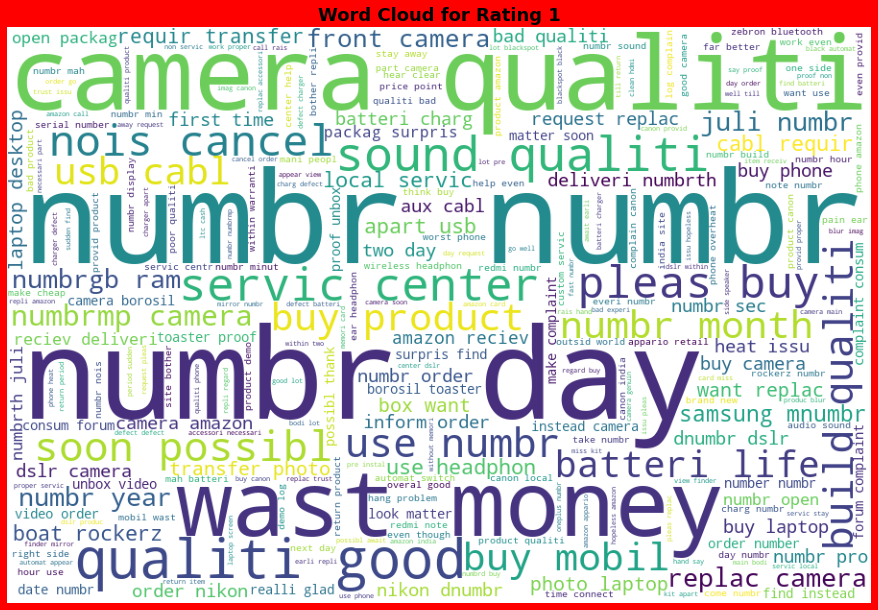

In [16]:
#Getting sense of words in Rating 1
one = df['Product_Review'][df['Ratings']==1.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 1',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

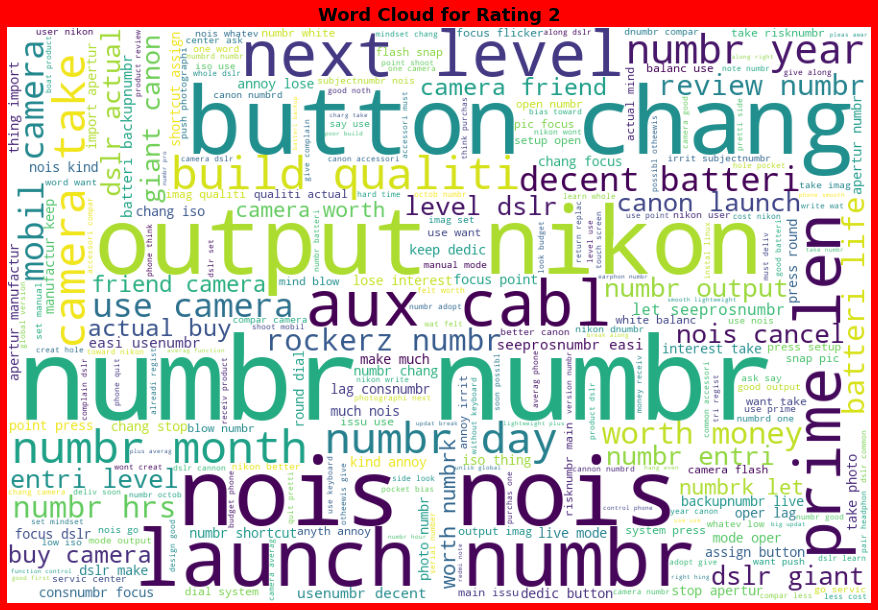

In [18]:
one = df['Product_Review'][df['Ratings']==2.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 2',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

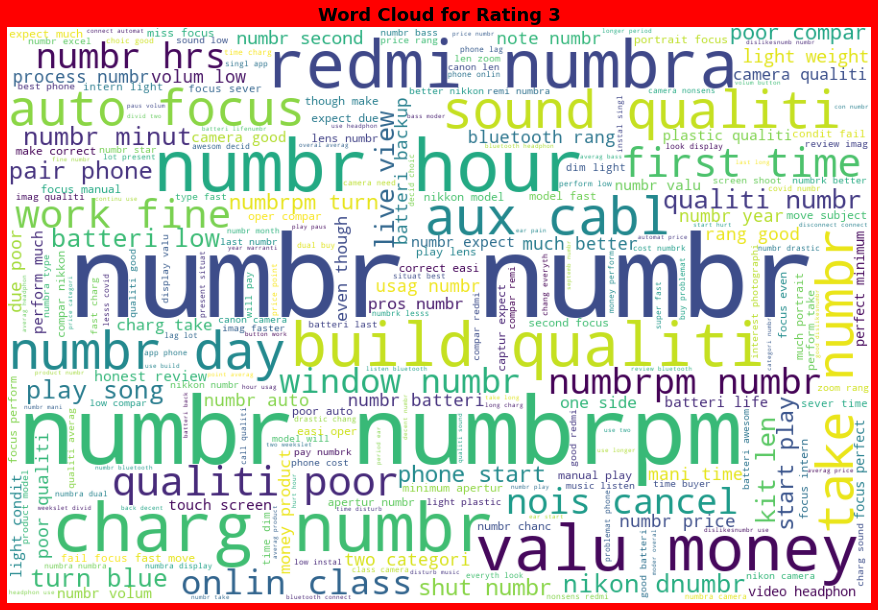

In [19]:
one = df['Product_Review'][df['Ratings']==3.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 3',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

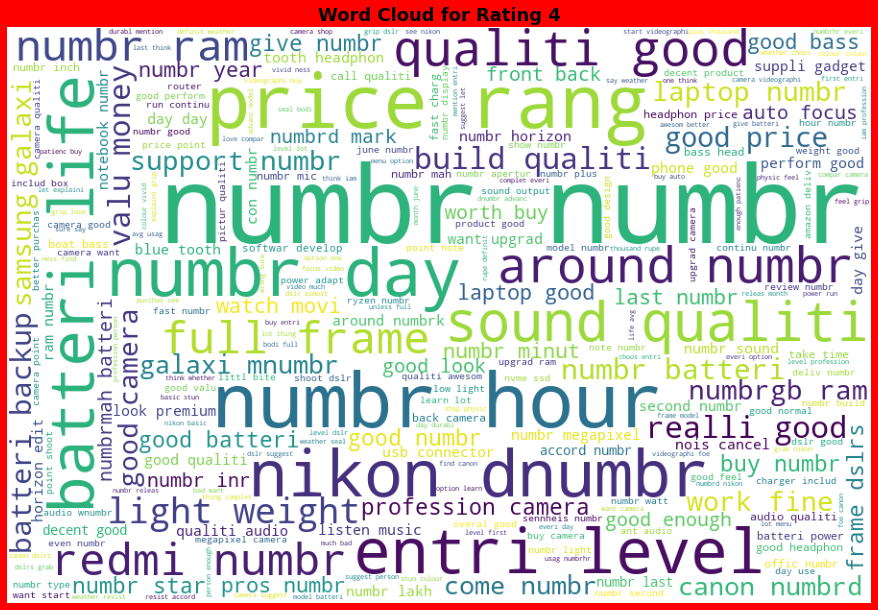

In [20]:
one = df['Product_Review'][df['Ratings']==4.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 4',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

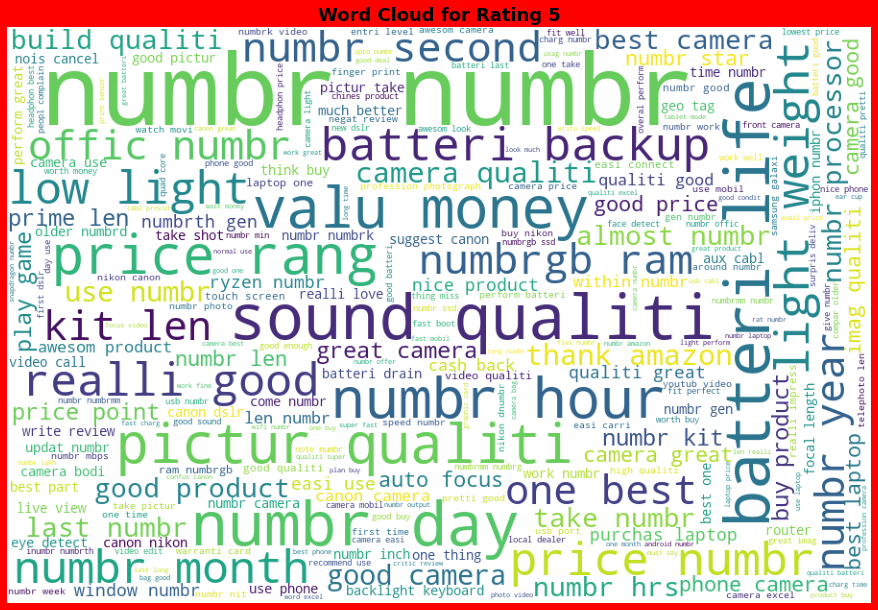

In [21]:
one = df['Product_Review'][df['Ratings']==5.0]
one_cloud = WordCloud(width=900,height=600,background_color='white',max_words=250).generate(' '.join(one))
plt.figure(figsize=(12,9),facecolor='r')
plt.imshow(one_cloud)
plt.axis('off')
plt.title('Word Cloud for Rating 5',fontsize=18,fontweight ='bold')
plt.tight_layout(pad=0)
plt.show()

In [14]:
# Converting text into numeric using TfidfVectorizer
tf = TfidfVectorizer()
features = tf.fit_transform(df['Product_Review'])
X=features
Y=df[['Ratings']]

In [17]:
X.shape

(50000, 5824)

In [19]:
Y.shape

(50000, 1)

# Model Building

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=67, test_size=.3)
print('Training feature matrix size:',X_train.shape)
print('Training target vector size:',Y_train.shape)
print('Test feature matrix size:',X_test.shape)
print('Test target vector size:',Y_test.shape)

Training feature matrix size: (35000, 5824)
Training target vector size: (35000, 1)
Test feature matrix size: (15000, 5824)
Test target vector size: (15000, 1)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,f1_score
maxAccu=0
maxRS=0
for i in range(50,100):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.3, random_state=i)
    log_reg=LogisticRegression()
    log_reg.fit(X_train,Y_train)
    y_pred=log_reg.predict(X_test)
    acc=accuracy_score(Y_test,y_pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print('Best accuracy is', maxAccu ,'on Random_state', maxRS)

Best accuracy is 0.907 on Random_state 71


In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=71, test_size=.3)

# Logistic Regression

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=71, test_size=.3)
log_reg=LogisticRegression()
log_reg.fit(X_train,Y_train)
y_pred=log_reg.predict(X_test)
print('\033[1m'+'Logistics Regression Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Logistics Regression :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Logistics Regression :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Logistics Regression'+'\033[0m \n',classification_report(Y_test, y_pred))

Logistics Regression Evaluation


Accuracy Score of Logistics Regression : 0.907


Confusion matrix of Logistics Regression : 
 [[3330    7    3    9   29]
 [  35  573    0    2    7]
 [  42    0  820   13  232]
 [  36    3    5 1712  713]
 [ 121    5   17  116 7170]]


classification Report of Logistics Regression 
               precision    recall  f1-score   support

           1       0.93      0.99      0.96      3378
           2       0.97      0.93      0.95       617
           3       0.97      0.74      0.84      1107
           4       0.92      0.69      0.79      2469
           5       0.88      0.97      0.92      7429

    accuracy                           0.91     15000
   macro avg       0.94      0.86      0.89     15000
weighted avg       0.91      0.91      0.90     15000



In [23]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(log_reg, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', log_reg, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score LogisticRegression() :

CVScore : [0.5335 0.5184 0.6034 0.6531 0.5914]
Mean CV Score : 0.57996
Std deviation : 0.048944728010277085


# Decision Tree Classifier

In [24]:
dtc=DecisionTreeClassifier()
dtc.fit(X_train,Y_train)
y_pred=dtc.predict(X_test)
print('\033[1m'+'Decision Tree Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Decision Tree Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Decision Tree Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Decision Tree Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Decision Tree Classifier Evaluation


Accuracy Score of Decision Tree Classifier : 0.8971333333333333


Confusion matrix of Decision Tree Classifier : 
 [[3338    7    3    9   21]
 [  35  573    0    2    7]
 [  38    1  827   40  201]
 [  37    7   23 1810  592]
 [ 124    7   87  302 6909]]


classification Report of Decision Tree Classifier 
               precision    recall  f1-score   support

           1       0.93      0.99      0.96      3378
           2       0.96      0.93      0.95       617
           3       0.88      0.75      0.81      1107
           4       0.84      0.73      0.78      2469
           5       0.89      0.93      0.91      7429

    accuracy                           0.90     15000
   macro avg       0.90      0.87      0.88     15000
weighted avg       0.90      0.90      0.89     15000



In [25]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(dtc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', dtc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score DecisionTreeClassifier() :

CVScore : [0.4632 0.4821 0.5864 0.5774 0.5955]
Mean CV Score : 0.5409200000000001
Std deviation : 0.056353150754860214


# RandomForest Classifier

In [18]:
rfc=RandomForestClassifier()
rfc.fit(X_train,Y_train)
y_pred=rfc.predict(X_test)
print('\033[1m'+'Random Forest Classifier'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Random Forest Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Random Forest Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Random Forest Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Random Forest Classifier


Accuracy Score of Random Forest Classifier : 0.9134


Confusion matrix of Random Forest Classifier : 
 [[3334    7    3    9   25]
 [  35  573    0    2    7]
 [  36    0  821   11  239]
 [  23    3    7 1740  696]
 [  79    4   17   96 7233]]


classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

           1       0.95      0.99      0.97      3378
           2       0.98      0.93      0.95       617
           3       0.97      0.74      0.84      1107
           4       0.94      0.70      0.80      2469
           5       0.88      0.97      0.93      7429

    accuracy                           0.91     15000
   macro avg       0.94      0.87      0.90     15000
weighted avg       0.92      0.91      0.91     15000



In [27]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(rfc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', rfc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score RandomForestClassifier() :

CVScore : [0.5537 0.4886 0.5744 0.612  0.5817]
Mean CV Score : 0.56208
Std deviation : 0.04122685532513971


# AdaBoost Classifier

In [30]:
adbc=AdaBoostClassifier()
adbc.fit(X_train,Y_train)
y_pred=adbc.predict(X_test)
print('\033[1m'+'AdaBoost Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of AdaBoost Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of AdaBoost Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of AdaBoost Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

AdaBoost Classifier Evaluation


Accuracy Score of AdaBoost Classifier : 0.5914666666666667


Confusion matrix of AdaBoost Classifier : 
 [[1433    3   87   65 1790]
 [ 211  175    0   19  212]
 [  63    0  246   39  759]
 [ 133    0    7   41 2288]
 [ 299    5   62   86 6977]]


classification Report of AdaBoost Classifier 
               precision    recall  f1-score   support

           1       0.67      0.42      0.52      3378
           2       0.96      0.28      0.44       617
           3       0.61      0.22      0.33      1107
           4       0.16      0.02      0.03      2469
           5       0.58      0.94      0.72      7429

    accuracy                           0.59     15000
   macro avg       0.60      0.38      0.41     15000
weighted avg       0.55      0.59      0.52     15000



In [31]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(adbc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score',adbc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score AdaBoostClassifier() :

CVScore : [0.4397 0.4566 0.5635 0.5642 0.5499]
Mean CV Score : 0.51478
Std deviation : 0.05490229139116146


# Gradient Boosting Classifier

In [21]:
grad_bc=GradientBoostingClassifier()
grad_bc.fit(X_train,Y_train)
y_pred=grad_bc.predict(X_test)
print('\033[1m'+'Gradient Boosting Classifier Evaluation'+'\033[0m')
print('\n')
print('\033[1m'+'Accuracy Score of Gradient Boosting Classifier :'+'\033[0m', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Gradient Boosting Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'classification Report of Gradient Boosting Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Gradient Boosting Classifier Evaluation


Accuracy Score of Gradient Boosting Classifier : 0.9035333333333333


Confusion matrix of Gradient Boosting Classifier : 
 [[3205    7    3    9  154]
 [  22  573    0    2   20]
 [  26    0  820    8  253]
 [  41    3    8 1700  717]
 [ 118    4   10   42 7255]]


classification Report of Gradient Boosting Classifier 
               precision    recall  f1-score   support

           1       0.94      0.95      0.94      3378
           2       0.98      0.93      0.95       617
           3       0.98      0.74      0.84      1107
           4       0.97      0.69      0.80      2469
           5       0.86      0.98      0.92      7429

    accuracy                           0.90     15000
   macro avg       0.94      0.86      0.89     15000
weighted avg       0.91      0.90      0.90     15000



In [22]:
from sklearn.model_selection import cross_val_score
CVscore = cross_val_score(grad_bc, X, Y, cv =5)
print('\033[1m'+'Cross Validation Score', grad_bc, ':'+'\033[0m\n')
print("CVScore :" ,CVscore)
print("Mean CV Score :",CVscore.mean())
print("Std deviation :",CVscore.std())

Cross Validation Score GradientBoostingClassifier() :

CVScore : [0.5675 0.5694 0.6441 0.6529 0.6028]
Mean CV Score : 0.6073400000000001
Std deviation : 0.035984140951257966


We can see that RandomForestClassifier() gives us good Accuracy and maximum f1 score along with best Cross-validation score. we will apply Hyperparameter tuning on Random Forest model and Used it as final model.

# Hyper Parameter Tuning : GridSearchCV

In [19]:
from sklearn.model_selection import GridSearchCV

In [22]:
parameter = { 'max_features': ['auto', 'log2'], 
              'criterion':['gini','entropy'],
              'n_estimators': [75,100,150]}

In [23]:
GCV = GridSearchCV(RandomForestClassifier(),parameter,verbose=10)
GCV.fit(X_train,Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 1/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75; total time= 1.9min
[CV 2/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 2/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75; total time= 1.9min
[CV 3/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 3/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75; total time= 1.9min
[CV 4/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 4/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75; total time= 1.9min
[CV 5/5; 1/12] START criterion=gini, max_features=auto, n_estimators=75.........
[CV 5/5; 1/12] END criterion=gini, max_features=auto, n_estimators=75; total time= 1.9min
[CV 1/5; 2/12] START criterion=gini, max_features=auto, n_estimators=100........
[CV

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [75, 100, 150]},
             verbose=10)

In [24]:
GCV.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 150}

# Final Model

In [20]:
Final_mod = RandomForestClassifier(criterion='entropy',n_estimators= 150,max_features='auto')
Final_mod.fit(X_train,Y_train)
y_pred=Final_mod.predict(X_test)
print('\033[1m'+'Final Random Forest Classifier Model'+'\033[0m')
print('\033[1m'+'Accuracy Score :'+'\033[0m\n', accuracy_score(Y_test, y_pred))
print('\n')
print('\033[1m'+'Confusion matrix of Random Forest Classifier :'+'\033[0m \n',confusion_matrix(Y_test, y_pred))
print('\n')
print('\033[1m'+'Classification Report of Random Forest Classifier'+'\033[0m \n',classification_report(Y_test, y_pred))

Final Random Forest Classifier Model
Accuracy Score :
 0.9130666666666667


Confusion matrix of Random Forest Classifier : 
 [[3338    7    3    9   21]
 [  35  573    0    2    7]
 [  36    0  821   12  238]
 [  28    3    7 1734  697]
 [  91    4   14   90 7230]]


Classification Report of Random Forest Classifier 
               precision    recall  f1-score   support

           1       0.95      0.99      0.97      3378
           2       0.98      0.93      0.95       617
           3       0.97      0.74      0.84      1107
           4       0.94      0.70      0.80      2469
           5       0.88      0.97      0.93      7429

    accuracy                           0.91     15000
   macro avg       0.94      0.87      0.90     15000
weighted avg       0.92      0.91      0.91     15000

